##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Algoritmos federados personalizados, parte 2: implementando o cálculo federado de médias

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver em TensorFlow.org</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Executar no Google Colab</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/pt-br/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fonte no GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/pt-br/federated/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Baixar notebook</a>
</td>
</table>

Este tutorial é a segunda parte de uma série de duas partes que demonstra como implementar tipos personalizados de algoritmos federados no TFF usando o [Federated Core (FC)](../federated_core.md), que serve como base para a camada de [aprendizado federado (FL)](../federated_learning.md) (`tff.learning`).

Recomendamos que você leia a [primeira parte dessa série](custom_federated_algorithms_1.ipynb) antes, que apresenta alguns dos principais conceitos e abstrações de programação usadas aqui.

Essa segunda parte da série usa os mecanismos apresentados na primeira parte para implementar uma versão mais simples de algoritmos de avaliação e treinamento federado.

Incentivamos você a ler os tutoriais de [classificação de imagens](federated_learning_for_image_classification.ipynb) e [geração de texto](federated_learning_for_text_generation.ipynb) para uma introdução de nível superior mais gentil às APIs de aprendizado federado do TFF, já que ajudarão você a contextualizar os conceitos descritos aqui.

## Antes de começarmos

Antes de começar, tente executar o seguinte exemplo "Olá, mundo" para garantir que o ambiente esteja configurado corretamente. Se não funcionar, consulte as instruções no guia de [instalação](../install.md).

In [ ]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow-federated

In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

In [2]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

b'Hello, World!'

## Implementação do cálculo federado de médias

Como na [classificação de imagens do aprendizado federado](federated_learning_for_image_classification.ipynb), vamos usar o exemplo MNIST. Porém, como a intenção é que este tutorial seja de baixo nível, vamos contornar a API do Keras e a `tff.simulation`, escrever código de modelo bruto e construir um dataset federado do zero.


### Preparação dos datasets federados

Para fins de demonstração, vamos simular um cenário em que temos dados de 10 usuários, e cada um contribui com conhecimento de como reconhecer um dígito diferente. Não dá para ser mais não [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) que isso.

Primeiro, vamos carregar os dados MNIST padrão:

In [3]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [4]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

Os dados são arrays Numpy, um com imagens e outro com rótulos de dígitos, ambos com a primeira dimensão passando os exemplos individuais. Vamos escrever uma função helper que a formate de uma maneira compatível com a forma como alimentamos sequências federadas em computações do TFF, ou seja, como uma lista de listas — a lista externa abrangendo os usuários (dígitos), as internas abrangendo lotes de dados na sequência de cada cliente. Como costume, vamos estruturar cada lote como um par de tensores chamados `x` e `y`, cada um com a dimensão de lote principal. Enquanto isso, também vamos achatar cada imagem em um vetor de 784 elementos e redimensionar os pixels para o intervalo `0..1`. Assim, não precisamos encher a lógica do modelo com conversões de dados.

In [5]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

Como teste rápido de sanidade, vamos ver o tensor `Y` no último lote de dados contribuídos pelo quinto cliente (correspondente ao dígito `5`).

In [6]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

Só para ter certeza, vamos conferir também a imagem correspondente ao último elemento desse lote.

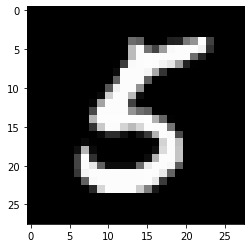

In [7]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

### Combinando TensorFlow e TFF

Neste tutorial, para simplificar, vamos decorar imediatamente funções que introduzem a lógica do TensorFlow com `tff.tf_computation`. Porém, para lógicas mais complexas, não é o padrão que recomendamos. A depuração do TensorFlow já pode ser um desafio, e a depuração do TensorFlow depois de totalmente serializado e reimportado perde necessariamente alguns metadados e limita a interatividade, deixando a depuração ainda mais desafiadora.

Portanto, **recomendamos escrever uma lógica do TF complexa como funções Python independentes** (ou seja, sem decoração de `tff.tf_computation`). Assim, a lógica do TensorFlow pode ser desenvolvida e testada usando as práticas recomendadas e ferramentas do TF (como o modo eager), antes de serializar a computação para o TFF (por exemplo, invocando `tff.tf_computation` com uma função Python como argumento).

### Definição de uma função de perda

Agora que temos os dados, vamos definir uma função de perda que possa ser usada para treinamento. Primeiro, vamos definir o tipo de entrada como uma tupla nomeada do TFF. Como o tamanho dos lotes de dados pode variar, definimos a dimensão do lote como `None`, indicando que o tamanho dessa dimensão é desconhecido.

In [8]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

Você talvez se pergunte por que não podemos apenas definir um tipo Python comum. Lembre-se da discussão na [parte 1](custom_federated_algorithms_1.ipynb), onde explicamos que, embora seja possível expressar a lógica computacional do TFF usando Python, em segundo plano, as computações do TFF *não são* Python. O símbolo `BATCH_TYPE` definido acima representa uma especificação de tipo abstrato do TFF. É importante distinguir esse tipo *abstrato* do TFF dos tipos de *representação* do Python concretos. Por exemplo, containers como `dict` ou `collections.namedtuple` que podem ser usados para representar o tipo do TFF no corpo de uma função Python. Ao contrário do Python, o TFF tem um único construtor de tipo abstrato `tff.StructType` para containers semelhantes a tuplas, com elementos que podem ser nomeados individualmente ou deixados sem nome. Esse tipo também é usado para modelar parâmetros formais de computações, já que as computações do TFF podem declarar formalmente apenas um parâmetro e um resultado — você verá exemplos disso em breve.

Agora vamos definir o tipo do TFF dos parâmetros do modelo, novamente como uma tupla nomeada do TFF de *pesos* e *bias*.

In [9]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)
print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


Depois dessas definições, podemos definir a perda de um determinado modelo, em um único lote. Observe o uso do decorador `@tf.function` dentro do decorador `@tff.tf_computation`. Isso nos permite escrever código TF usando semântica semelhante à do Python, mesmo dentro de um contexto `tf.Graph` criado pelo decorador `tff.tf_computation`.

In [10]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

Como esperado, a computação `batch_loss` retorna a perda de `float32` considerando o modelo e um único lote de dados. Observe como `MODEL_TYPE` e `BATCH_TYPE` foram agrupados em duas tuplas de parâmetros formais. Você pode reconhecer o tipo de `batch_loss` como `(<MODEL_TYPE,BATCH_TYPE> -> float32)`.

In [11]:
str(batch_loss.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>> -> float32)'

Como teste de sanidade, vamos construir um modelo inicial cheio de zeros e calcular a perda no lote de dados visualizado acima.

In [12]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025851

Alimentamos a computação do TFF com o modelo inicial definido como um `dict`, mesmo que o corpo da função Python que o define consuma parâmetros do modelo como `model['weight']` e `model['bias']`. Os argumentos da chamada de `batch_loss` não são apenas passados para o corpo dessa função.

O que acontece quando invocamos `batch_loss`? Já foi realizado o tracing e a serialização do corpo em Python de `batch_loss` na célula acima onde foi definido. O TFF faz a chamada de `batch_loss` no tempo de definição da computação e é alvo da invocação no momento em que `batch_loss` é invocada. Em ambas as funções, o TFF serve como uma ponte entre o sistema de tipos abstratos do TFF e os tipos de representação do Python. No momento da invocação, o TFF aceitará a maioria dos tipos de container Python padrão (`dict`, `list`, `tuple`, `collections.namedtuple` etc.) como representações concretas de tuplas do TFF abstratas. Além disso, como observado acima, mesmo que as computações do TFF só aceitem formalmente um único parâmetro, você pode usar a sintaxe de chamada familiar do Python com argumentos posicionais e/ou de palavras-chave quando o tipo do parâmetro é uma tupla — funciona como esperado.

### Método do gradiente descendente em um único lote

Agora, vamos definir uma computação que use essa função de perda para realizar uma única etapa de método do gradiente descendente. Veja como, ao definir essa função, usamos `batch_loss` como um subcomponente. Você pode invocar uma computação construída com `tff.tf_computation` dentro do corpo de outra computação, embora geralmente não seja necessário — como observado acima, a serialização perde informações de depuração, então é geralmente preferível para computações mais complexas para escrever e testar todo o código TensorFlow sem o decorador `tff.tf_computation`.

In [13]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [14]:
str(batch_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,batch=<x=float32[?,784],y=int32[?]>,learning_rate=float32> -> <weights=float32[784,10],bias=float32[10]>)'

Ao invocar uma função Python decorada com `tff.tf_computation` no corpo de outra função desse tipo, a lógica da computação interna do TFF é incorporada (basicamente, inline) na lógica da externa. Como observado acima, se você estiver escrevendo as duas computações, é provavelmente melhor transformar a função interna (nesse caso, `batch_loss`) em Python normal ou `tf.function` em vez de `tff.tf_computation`. No entanto, ilustramos aqui que chamar uma `tff.tf_computation` dentro de outra funciona basicamente como esperado. Isso pode ser necessário se, por exemplo, você não tiver o código Python que define `batch_loss`, mas apenas a representação do TFF serializada.

Agora, vamos aplicar essa função algumas vezes ao modelo inicial para ver se a perda diminui.

In [15]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [16]:
losses

[0.19690025, 0.13176318, 0.101132266, 0.08273812, 0.0703014]

### Método do gradiente descendente em uma sequência de dados locais

Agora, como `batch_train` parece funcionar, vamos escrever uma função de treinamento `local_train` semelhante que consome a sequência inteira de todos os lotes de um usuário, em vez de apenas um lote. A nova computação agora precisará consumir `tff.SequenceType(BATCH_TYPE)` em vez de `BATCH_TYPE`.

In [17]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
  
  # Reduction function to apply to each batch.
  @tff.federated_computation((MODEL_TYPE, tf.float32), BATCH_TYPE)
  def batch_fn(model_with_lr, batch):
    model, lr = model_with_lr
    return batch_train(model, batch, lr), lr

  trained_model, _ = tff.sequence_reduce(
      all_batches, (initial_model, learning_rate), batch_fn
  )
  return trained_model

In [18]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[784,10],bias=float32[10]>,learning_rate=float32,all_batches=<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

Essa breve seção de código contém vários detalhes. Vamos analisar cada um.

Primeiro, embora seja possível implementar toda essa lógica no TensorFlow, contando com `tf.data.Dataset.reduce` para processar a sequência de forma parecida com o que fizemos antes, desta vez optamos por expressar a lógica na linguagem glue, como uma `tff.federated_computation`. Usamos o operador federado `tff.sequence_reduce` para realizar a redução.

O operador `tff.sequence_reduce` é usado de maneira semelhante a `tf.data.Dataset.reduce`. Ele pode ser considerado praticamente igual a `tf.data.Dataset.reduce`, mas é usado em computações federadas, que, como você deve lembrar, não podem conter código TensorFlow. É um operador de modelo com um parâmetro formal de três tuplas que consiste em uma *sequência* de elementos do tipo `T`, o estado inicial da redução (vamos fazer referência a ele abstratamente como *zero*) de um tipo `U` e o *operador de redução* do tipo `(<U,T> -> U)` que altera o estado da redução processando um único elemento. O resultado é o estado final da redução, após processar todos os elementos em ordem sequencial. Em nosso exemplo, o estado da redução é o modelo treinado em um prefixo dos dados, e os elementos são lotes de dados.

Em segundo lugar, observe que usamos novamente uma computação (`batch_train`) como um componente dentro de outro (`local_train`), mas não diretamente. Não podemos usá-lo como operador de redução porque ele recebe um parâmetro adicional: a taxa de aprendizado. Para resolver isso, definimos uma computação federada incorporada `batch_fn` que se vincula ao parâmetro `learning_rate` do `local_train` no seu corpo. Uma computação filha definida dessa forma pode capturar um parâmetro formal da sua mãe, desde que a computação filha não seja invocada fora do corpo da mãe. Pense nesse padrão como equivalente a `functools.partial` em Python.

A implicação prática de capturar a `learning_rate` dessa maneira é, claro, que o mesmo valor de taxa de aprendizado é usado em todos os lotes.

Agora, vamos testar a função de treinamento local recém-definida em toda a sequência de dados do mesmo usuário que contribuiu com o lote de amostra (dígito `5`).

In [19]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

Funcionou? Para responder a essa pergunta, precisamos implementar a avaliação.

### Avaliação local

Esta é uma maneira de implementar a avaliação local ao somar as perdas de todos os lotes de dados (também seria possível calcular a média; vamos deixar isso como um exercício para o leitor).

In [20]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):

  @tff.tf_computation((MODEL_TYPE, tf.float32), BATCH_TYPE)
  def accumulate_evaluation(model_and_accumulator, batch):
    model, accumulator = model_and_accumulator
    return model, accumulator + batch_loss(model, batch)

  _, total_loss = tff.sequence_reduce(
      all_batches, (model, 0.0), accumulate_evaluation
  )
  return total_loss

In [21]:
str(local_eval.type_signature)

'(<model=<weights=float32[784,10],bias=float32[10]>,all_batches=<x=float32[?,784],y=int32[?]>*> -> float32)'

Novamente, há alguns elementos novos ilustrados nesse código, vamos analisá-los um a um.

Primeiro, usamos dois novos operadores federados para processar sequências: `tff.sequence_map`, que aceita uma *função de mapeamento* `T->U` e uma *sequência* de `T` e emite uma sequência de `U` obtida ao aplicar a função de mapeamento pontual, e `tff.sequence_sum`, que apenas soma todos os elementos. Mapeamos cada lote de dados a um valor de perda e, em seguida, adicionamos os valores de perda resultantes para calcular a perda total.

Também seria possível usar `tff.sequence_reduce` novamente, mas essa não é a melhor escolha — o processo de redução é, por definição, sequencial, enquanto o mapeamento e a soma podem ser calculados em paralelo. Quando for possível escolher, é melhor ficar com operadores que não restringem as escolhas de implementação. Assim, quando nossa computação do TFF for compilada no futuro para ser implantada em um ambiente específico, será possível aproveitar ao máximo todas as oportunidades possíveis para uma execução mais rápida, mais escalonável e com maior eficiência de recursos.

Segundo, assim como em `local_train`, a função do componente que precisamos (`batch_loss`) aceita mais parâmetros do que o operador federado (`tff.sequence_map`) espera, então definimos novamente uma parcial, desta vez inline, ao envolver diretamente um `lambda` como uma `tff.federated_computation`. Usar wrappers inline com uma função como argumento é a maneira recomendada de usar `tff.tf_computation` para incorporar a lógica do TensorFlow no TFF.

Agora, vamos ver se o treinamento funcionou.

In [22]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.43484688


Realmente, a perda diminuiu. Mas e se avaliarmos isso nos dados de outro usuário?

In [23]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 74.50075


Como esperado, as coisas pioraram. O modelo foi treinado para reconhecer `5` e nunca viu um `0`. Isso levanta a questão: como é que o treinamento local afetou a qualidade do modelo de uma perspectiva global?

### Avaliação federada

Este é o ponto da jornada em que finalmente voltamos aos tipos federados e às computações federadas — o tema com o qual começamos. Confira um par de definições de tipos do TFF para o modelo que se origina no servidor e os dados que permanecem nos clientes.

In [24]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

Com todas as definições apresentadas até agora, expressar a avaliação federada no TFF é trivial: distribuímos o modelo aos clientes, deixamos cada cliente invocar a avaliação local na sua porção de dados local e calculamos a média da perda. Veja uma maneira de escrever isso.

In [25]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model),  data]))

Já vimos exemplos de `tff.federated_mean` e `tff.federated_map` em cenários mais simples e, a nível intuitivo, elas funcionam como esperado. Porém, essa seção de código é mais complexa do que aparenta, então vamos examiná-la com cuidado.

Primeiro, vamos analisar a parte "*deixamos cada cliente invocar a avaliação local na sua porção de dados local*". Como mencionamos nas seções anteriores, `local_eval` tem uma assinatura de tipo no formato `(<MODEL_TYPE, LOCAL_DATA_TYPE> -> float32)`.

O operador federado `tff.federated_map` é um modelo que aceita como parâmetro duas tuplas que consistem na *função de mapeamento* de um tipo `T->U` e um valor federado do tipo `{T}@CLIENTS` (ou seja, com membros constituintes do mesmo tipo que o parâmetro da função de mapeamento) e retorna um resultado do tipo `{U}@CLIENTES`.

Como estamos alimentando `local_eval` como uma função de mapeamento que será aplicada a cada cliente, o segundo argumento deve ser um tipo federado `{<MODEL_TYPE, LOCAL_DATA_TYPE>}@CLIENTS`, ou seja, na nomenclatura das seções anteriores, deve ser uma tupla federada. Cada cliente deve conter um conjunto completo de argumentos para `local_eval` como um membro constituinte. Em vez disso, estamos alimentando-o com uma `list` Python de dois elementos. O que está acontecendo aqui?

Isso é um exemplo de uma *conversão de tipo implícito* no TFF, semelhante às conversões de tipo implícito que você talvez tenha visto em outros lugares, por exemplo, ao alimentar um `int` para uma função que aceita um `float`. Por enquanto, a conversão implícita é pouco usada, mas planejamos difundi-la mais no TFF como uma forma de reduzir o boilerplate.

A conversão implícita aplicada nesse caso é a equivalência entre tuplas federadas no formato `{<X,Y>}@Z` e tuplas de valores federados `<{X}@Z,{Y}@Z>`. Embora formalmente sejam assinaturas de tipos diferentes, da perspectiva dos programadores, cada dispositivo em `Z` contém duas unidades de dados `X` e `Y`. O que acontece aqui não é diferente do `zip` no Python e, realmente, oferecemos um operador `tff.federated_zip` para realizar essas conversões explicitamente. Quando o `tff.federated_map` se depara com uma tupla como um segundo argumento, ele simplesmente invoca `tff.federated_zip` para você.

Diante do exposto acima, agora você reconhece a expressão `tff.federated_broadcast(model)` como a representação de um valor de tipo do TFF `{MODEL_TYPE}@CLIENTS` e `data` como um valor de tipo do TFF `{LOCAL_DATA_TYPE}@CLIENTS` (ou simplesmente `CLIENT_DATA_TYPE`). Os dois são filtrados juntos por um `tff.federated_zip` implícito para formar o segundo argumento de `tff.federated_map`.

O operador `tff.federated_broadcast`, como esperado, simplesmente transfere os dados do servidor para os clientes.

Agora, vamos ver como nosso treinamento local afetou a perda média do sistema.

In [26]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 54.43263


Como esperado, a perda aumentou. Para melhorar o modelo para todos os usuários, vamos precisar treinar com os dados de todos.

### Treinamento federado

A maneira mais simples de implementar o treinamento federado é treinar localmente e, em seguida, calcular a média dos modelos. Isso utiliza os mesmos blocos básicos e padrões que já discutimos, como você pode ver abaixo.

In [27]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

Na implementação completa do cálculo federado de média fornecido por `tff.learning`, em vez de calcular a média dos modelos, preferimos calcular a média dos deltas dos modelos, por vários motivos, como a capacidade de cortar as normas de atualização, para compressão etc.

Vamos ver se o treinamento funciona executando algumas rodadas de treinamento e comparando a perda média antes e depois.

In [28]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
round 4, loss=17.457256317138672


Para completar, vamos executar também os dados de teste, confirmando se o modelo generaliza bem.

In [29]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767


Isso conclui nosso tutorial.

É claro que nosso exemplo simplificado não reflete uma série de coisas que você precisaria fazer em um cenário mais realista. Por exemplo, não calculamos outras métricas além da perda. Recomendamos que você estude a [implementação](https://github.com/tensorflow/federated/blob/main/tensorflow_federated/python/learning/federated_averaging.py) do cálculo federado de média em `tff.learning` como um exemplo mais completo e uma forma de demonstrar algumas das práticas de programação que queremos incentivar.